# Prepare Environment

In [1]:
!pip uninstall Pillow
!pip install Pillow

Uninstalling Pillow-7.0.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-7.0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled Pillow-7.0.0
     |████████████████████████████████| 2.2MB 3.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
!git clone https://github.com/julienguegan/Computer_Vision/
%cd "/content/Computer_Vision/Anomaly Detection/E-Net"
!pip install -r requirements.txt
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'Computer_Vision'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 314 (delta 126), reused 263 (delta 78), pack-reused 0
Receiving objects: 100% (314/314), 18.10 MiB | 27.17 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/Computer_Vision/Anomaly Detection/E-Net
     |████████████████████████████████| 952kB 3.5MB/s 
     |████████████████████████████████| 12.9MB 243kB/s 
     |████████████████████████████████| 17.3MB 120kB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 235kB 43.9MB/s 
     |████████████████████████████████| 591.8MB 21kB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.2 which is incompatible.

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 37.67 MiB/s, done.
Resolving deltas: 100% (81/81), done.


# Training


In [13]:
!python main.py -m train --save-dir save/ENet_CamVid/ --name PSPNet --dataset camvid --dataset-dir ./SegNet-Tutorial/CamVid --epochs 30


Loading dataset...

Selected dataset: camvid
Dataset directory: ./SegNet-Tutorial/CamVid
Save directory: save/ENet_CamVid/
Number of classes to predict: 12
Train dataset size: 367
Validation dataset size: 101
Image size: torch.Size([10, 3, 360, 480])
Label size: torch.Size([10, 360, 480])
Class-color encoding: OrderedDict([('sky', (128, 128, 128)), ('building', (128, 0, 0)), ('pole', (192, 192, 128)), ('road', (128, 64, 128)), ('pavement', (60, 40, 222)), ('tree', (128, 128, 0)), ('sign_symbol', (192, 128, 128)), ('fence', (64, 64, 128)), ('car', (64, 0, 128)), ('pedestrian', (64, 64, 0)), ('bicyclist', (0, 128, 192)), ('unlabeled', (0, 0, 0))])

Weighing technique: ENet
Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 5.7920,  4.4403, 34.0217,  3.4469, 15.9119,  9.0202, 32.0138, 32.4789,
        13.2071, 38.3877, 44.1345,  0.0000], device='cuda:0')

Training...

>>>> [Epoch: 0] Training
>>>> [Epoch: 0] Avg. loss: 2.3953 | Mean I

# Testing

In [1]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#!python main.py -m test --save-dir save/ENet_CamVid/ --name ENet --dataset camvid --dataset-dir ./SegNet-Tutorial/CamVid --imshow-batch
#plt.show()
# /!\ can't display figure on colab with python command ...

In [1]:
%cd "/content/Computer_Vision/Anomaly Detection/E-Net"

/content/Computer_Vision/Anomaly Detection/E-Net


## load librairies

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import transforms as ext_transforms
from models.enet import ENet
from models.pspnet import PSPNet
from train import Train
from test import Test
from metric.iou import IoU
from args import get_arguments
from data.utils import enet_weighing, median_freq_balancing
from data import CamVid as dataset
import utils
import anom_utils
import numpy as np 
from utils import *

## Parameters

In [3]:
class HyperParameters:

    def __init__(self):
        self.dataset      = 'camvid' # Dataset to use
        self.dataset_dir  = 'SegNet-Tutorial/CamVid' # Path to the root directory of the selected dataset.
        self.save_dir     = 'save/ENet_CamVid/'      # The directory where models are saved.
        self.height       = 360       # The image height
        self.width        = 480       # The image width
        self.batch_size   = 10        # The batch size
        self.workers      = 4         # Number of subprocesses to use for data loading
        self.imshow_batch = True      # Displays batch images when loading the dataset and making predictions
        self.weighing     = 'ENet'    # The class weighing technique to apply to the dataset ['enet', 'mfb', 'none']
        self.name         = 'ENet'    # Name given to the model when saving.
        self.print_step   = True      # Print loss every step
        self.ignore_unlabeled = False # The unlabeled class is ignored
        self.device       = torch.device('cuda')

args = HyperParameters()

## Load data

In [4]:
from load_dataset import load_dataset


Loading dataset...

Selected dataset: camvid
Dataset directory: SegNet-Tutorial/CamVid
Save directory: save/ENet_CamVid/
Number of classes to predict: 12
Train dataset size: 367
Validation dataset size: 101
Image size: torch.Size([10, 3, 360, 480])
Label size: torch.Size([10, 360, 480])
Class-color encoding: OrderedDict([('sky', (128, 128, 128)), ('building', (128, 0, 0)), ('pole', (192, 192, 128)), ('road', (128, 64, 128)), ('pavement', (60, 40, 222)), ('tree', (128, 128, 0)), ('sign_symbol', (192, 128, 128)), ('fence', (64, 64, 128)), ('car', (64, 0, 128)), ('pedestrian', (64, 64, 0)), ('bicyclist', (0, 128, 192)), ('unlabeled', (0, 0, 0))])


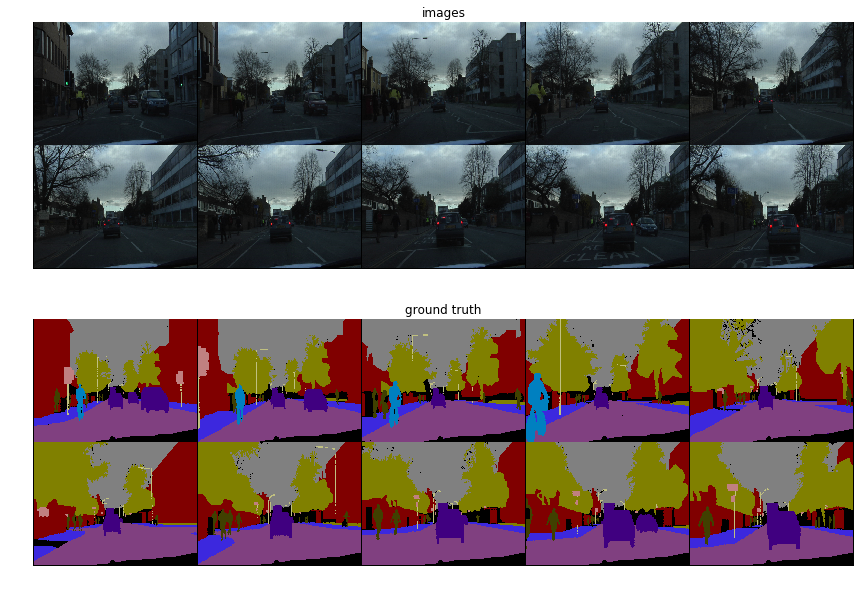


Weighing technique: ENet
Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 5.7920,  4.4403, 34.0217,  3.4469, 15.9119,  9.0202, 32.0138, 32.4789,
        13.2071, 38.3877, 44.1345, 17.3064], device='cuda:0')


In [5]:
loaders, class_weights, class_encoding = load_dataset(dataset, args)
train_loader, val_loader, test_loader  = loaders

In [6]:
%cd "/content/Computer_Vision/Anomaly Detection/E-Net"

/content/Computer_Vision/Anomaly Detection/E-Net


## Load model

In [18]:
num_classes = len(class_encoding)
model       = ENet(num_classes).to(args.device)
optimizer   = optim.Adam(model.parameters())
model       = utils.load_checkpoint(model, optimizer, args.save_dir, args.name)[0]

## Test

In [8]:
print("\nTesting...\n")
num_classes = len(class_encoding)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Evaluation metric
if args.ignore_unlabeled:
    ignore_index = list(class_encoding).index('unlabeled')
else:
    ignore_index = None
metric = IoU(num_classes, ignore_index=ignore_index)


Testing...



>>>> Running test dataset
[batch: 0] Iteration loss: 2.8911
[batch: 1] Iteration loss: 4.4655
[batch: 2] Iteration loss: 4.6192
[batch: 3] Iteration loss: 4.2110
[batch: 4] Iteration loss: 3.9116
[batch: 5] Iteration loss: 4.1976
[batch: 6] Iteration loss: 3.3282
[batch: 7] Iteration loss: 1.8480
[batch: 8] Iteration loss: 1.4212
[batch: 9] Iteration loss: 1.8002
[batch:10] Iteration loss: 1.5247
[batch:11] Iteration loss: 1.5595
[batch:12] Iteration loss: 1.5169
[batch:13] Iteration loss: 1.5938
[batch:14] Iteration loss: 1.9262
[batch:15] Iteration loss: 1.8252
[batch:16] Iteration loss: 2.2148
[batch:17] Iteration loss: 2.0407
[batch:18] Iteration loss: 1.8168
[batch:19] Iteration loss: 1.8060
[batch:20] Iteration loss: 2.0859
[batch:21] Iteration loss: 1.7516
[batch:22] Iteration loss: 2.1408
[batch:23] Iteration loss: 3.1949
>>>> Avg. loss: 2.4871
>>>> Avg. IoU : 0.4575
    ----------------------
    |classes    | IoU    |
    ----------------------
    |sky        | 0.8917 |
    

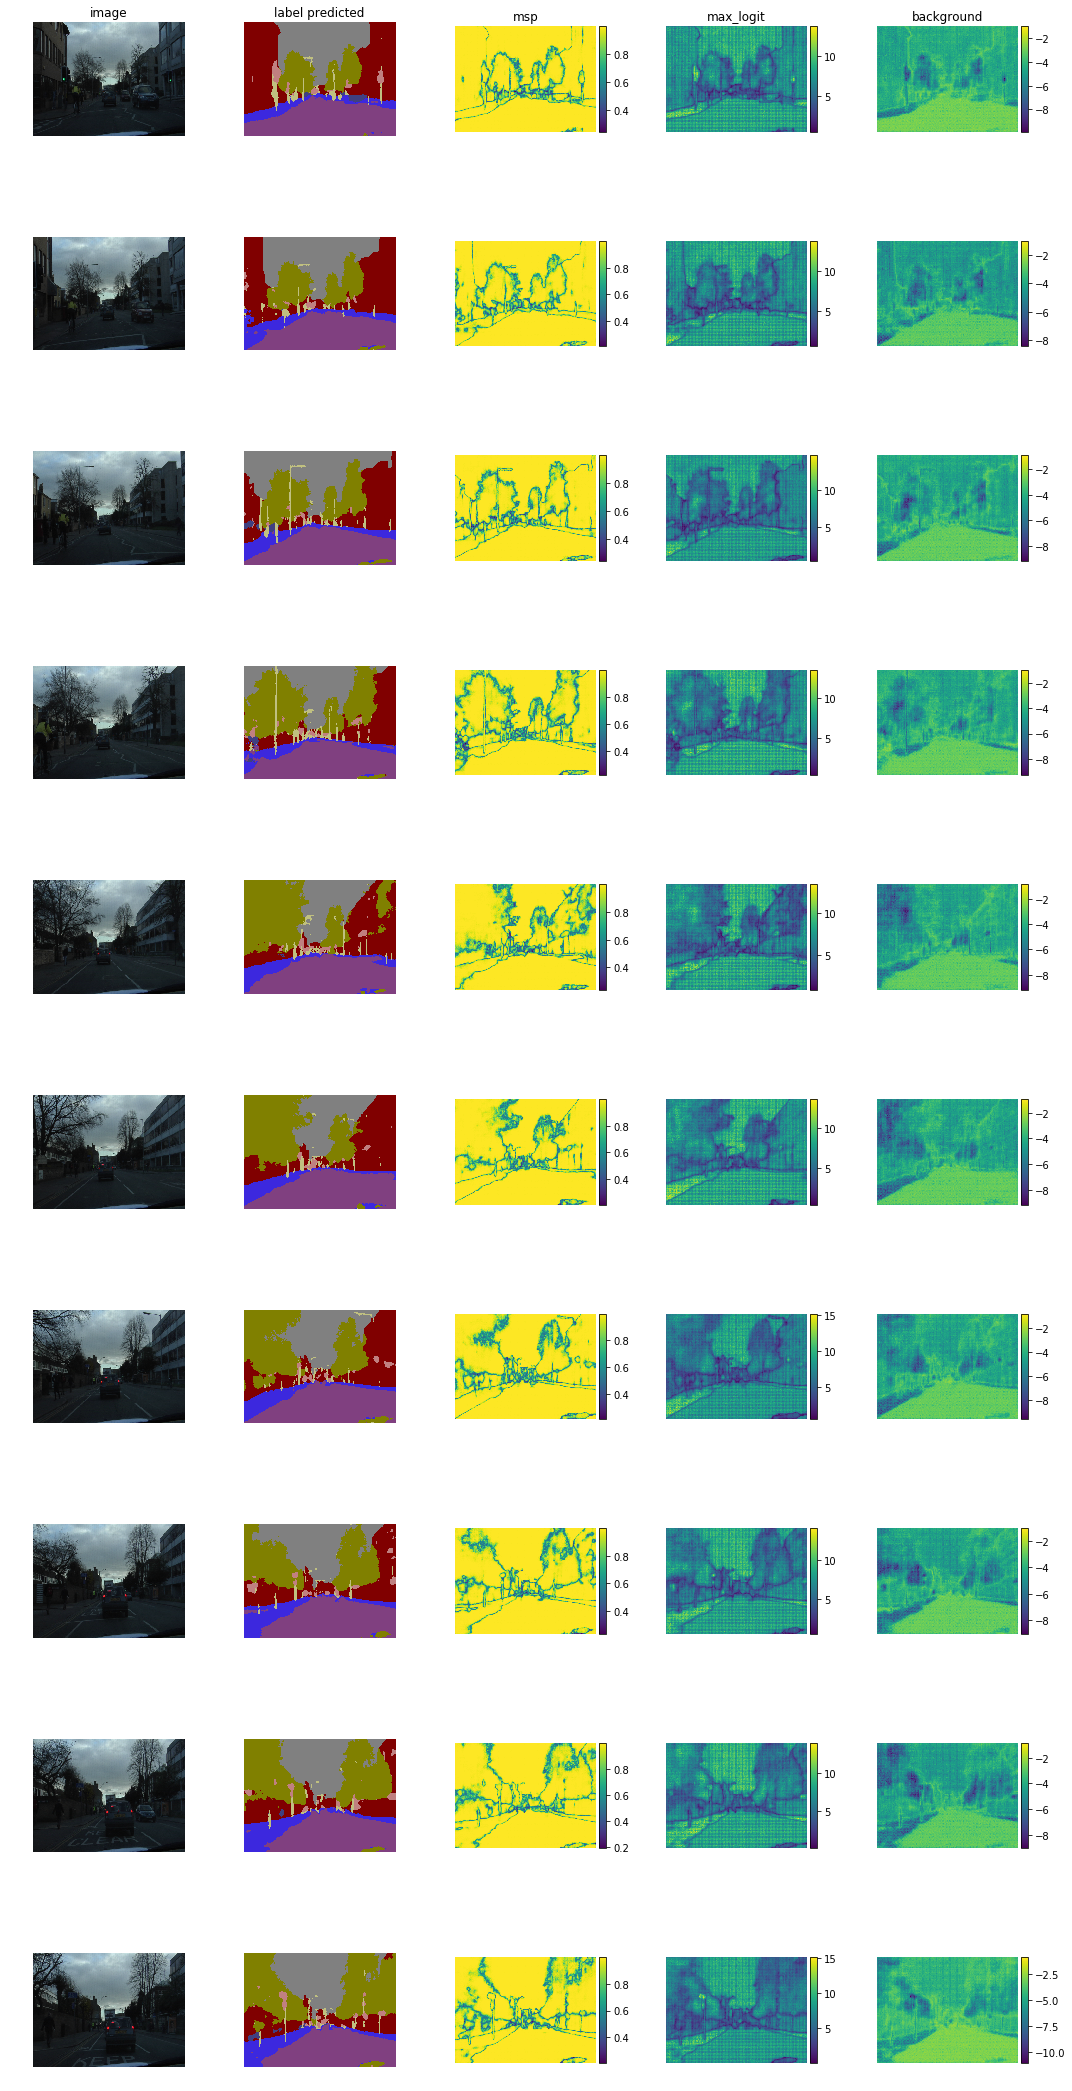

In [9]:
# Test the trained model on the test set
test = Test(model, test_loader, criterion, metric, args.device)
print(">>>> Running test dataset")
loss, (iou, miou), aurocs, auprs, fprs = test.run_epoch(args.print_step)
test.print_results(loss, miou, class_encoding, iou, aurocs, auprs, fprs, args)

# Temperature Scaling

In [10]:
del train_loader # otherwise "CUDA out of memory"

In [11]:
from temperature_scaling import ModelWithTemperature
temp_scaled_model = ModelWithTemperature(model)
temp_scaled_model.set_temperature(val_loader)

100%|██████████| 11/11 [00:02<00:00,  4.45it/s]


Before temperature - NLL: 0.832, ECE: 0.086
Optimal temperature: 2.239
After temperature - NLL: 0.555, ECE: 0.060


>>>> Running test dataset
[batch: 0] Iteration loss: 1.6134
[batch: 1] Iteration loss: 2.3057
[batch: 2] Iteration loss: 2.3656
[batch: 3] Iteration loss: 2.1873
[batch: 4] Iteration loss: 2.0815
[batch: 5] Iteration loss: 2.2189
[batch: 6] Iteration loss: 1.8538
[batch: 7] Iteration loss: 1.1319
[batch: 8] Iteration loss: 0.8847
[batch: 9] Iteration loss: 1.0674
[batch:10] Iteration loss: 0.9513
[batch:11] Iteration loss: 0.9770
[batch:12] Iteration loss: 1.0071
[batch:13] Iteration loss: 1.0486
[batch:14] Iteration loss: 1.1973
[batch:15] Iteration loss: 1.1485
[batch:16] Iteration loss: 1.2776
[batch:17] Iteration loss: 1.2277
[batch:18] Iteration loss: 1.1280
[batch:19] Iteration loss: 1.0903
[batch:20] Iteration loss: 1.2300
[batch:21] Iteration loss: 1.0802
[batch:22] Iteration loss: 1.2722
[batch:23] Iteration loss: 1.7506
>>>> Avg. loss: 1.4207
>>>> Avg. IoU : 0.4575
    ----------------------
    |classes    | IoU    |
    ----------------------
    |sky        | 0.8917 |
    

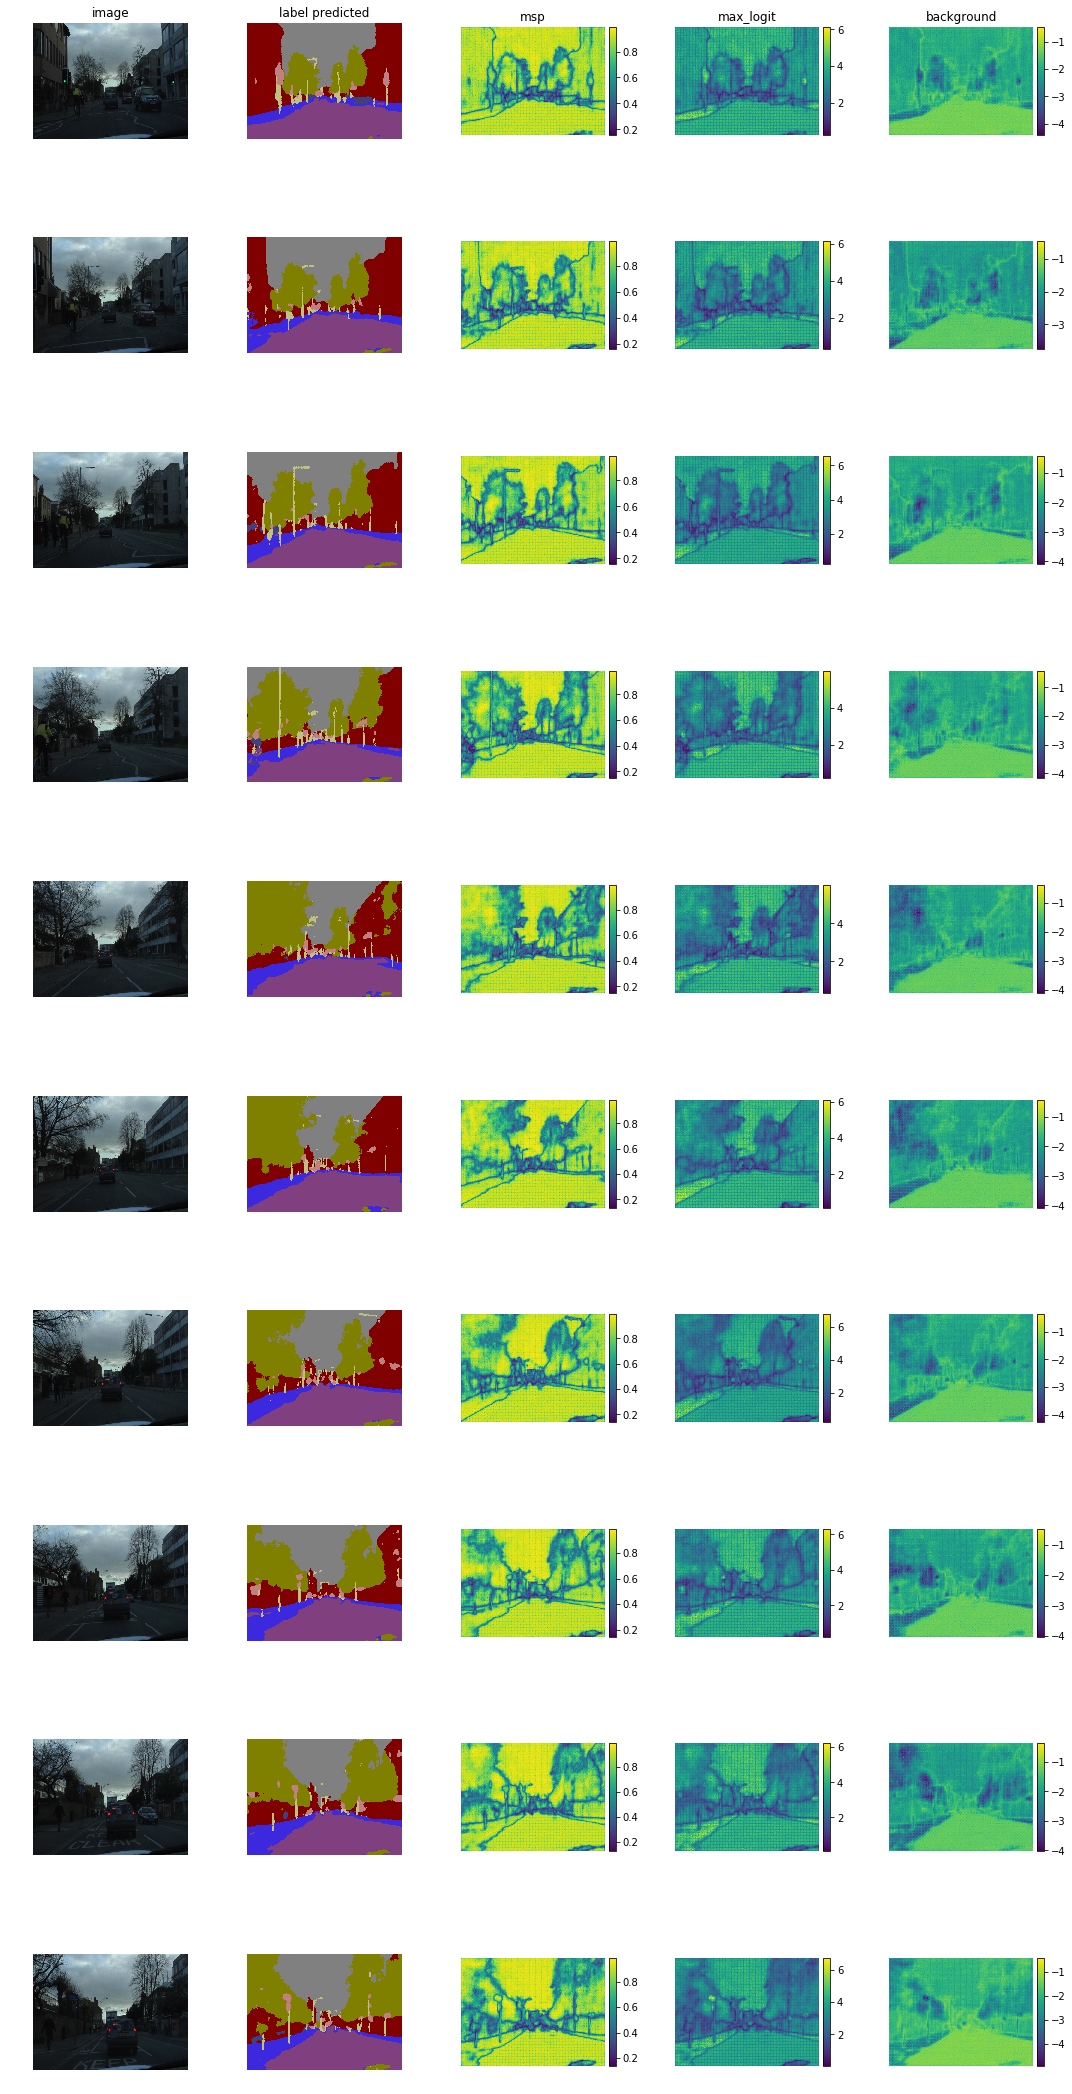

In [12]:
# Test the new model with temperature scaling on the test set
test = Test(temp_scaled_model, test_loader, criterion, metric, args.device)
print(">>>> Running test dataset")
loss, (iou, miou), aurocs, auprs, fprs = test.run_epoch(args.print_step)
test.print_results(loss, miou, class_encoding, iou, aurocs, auprs, fprs, args)